# Explore partial tile merge

Continuation of [202112-explore-SwissTopo-partial.ipynb], where we explore tile mask and tile merge.
Accompanying code mostly in [img_util.py]

## Prelude

In [1]:
%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

import sys
sys.path.append(os.path.realpath('../../eslope/development'))

In [2]:
# Preamble

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

from dataclasses import astuple
import io
import numpy as np
import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve

#external
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T

from src import bbox, mbt_util as M, img_util as G

In [3]:
dir = 'geo/data/sample_ch'
os.makedirs(dir, exist_ok=True)
%cd $dir

/home/me/code/eddy-geek/TIL/geo/data/sample_ch


In [4]:
# same definition used for download

bbchsw = bbox.BBox(5.976563, 45.706182,  7.734378, 46.800062)
bbchsc = bbox.BBox(7.734378, 45.706182,  9.492183, 46.800062)
bbchse = bbox.BBox(9.492183, 46.073229, 10.546877, 46.800062)
bbchc  = bbox.BBox(6.328128, 46.800062, 10.546877, 47.040180)
bbchn  = bbox.BBox(6.679684, 47.040180,  9.843748, 47.635785)

EPSILON = 0.000005

## Masking white part of tile

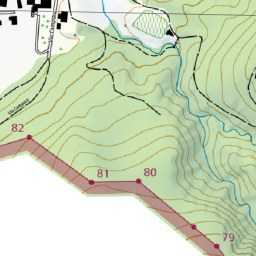

20219 20728 [(2, (255, 255, 233))] [(70, (0, 0, 2))]


In [29]:
imd5 = M.lnglat2tile('ch.mbtiles', 16, lng=9.0, lat=45.822)
assert(imd5)
display(Image(imd5))
im5 = Img.open(io.BytesIO(imd5))
c = im5.getcolors(65536)
print(len(imd5), len(c), c[:1], c[-1:])

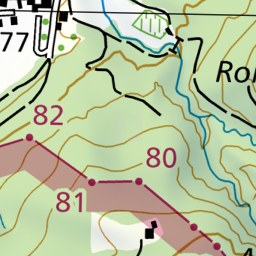

22960 27688 [(148, (255, 255, 255))] [(127, (0, 0, 0))]


In [30]:
imd6 = M.lnglat2tile('zzcch.mbtiles', 16, lng=9.0, lat=45.822)
assert(imd6)
display(Image(imd6))
im6 = Img.open(io.BytesIO(imd6))
c = im6.getcolors(65536)
print(len(imd6), len(c), c[:1], c[-1:])

In [165]:
np5 = G.to_numpy(im5)
np6 = G.to_numpy(im6)

In [166]:
np5[0, :20, :]

array([[  0,   0,   2],
       [  6,   6,   8],
       [  0,   0,   2],
       [  0,   0,   2],
       [  1,   1,   3],
       [  3,   3,   5],
       [ 13,  13,  15],
       [182, 182, 184],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [246, 246, 248],
       [214, 215, 217],
       [ 34,  35,  37],
       [ 18,  19,  21],
       [  7,   8,  10]], dtype=uint8)

In [47]:
import numpy as np
np.all(np5 == [0, 0, 0], axis=-1).sum()
# 19 black pixels

19

In [48]:
partial_mask = np.all(np5 == [255, 255, 255], axis=-1)
partial_mask.sum()
# 10K white pixels

10316

In [53]:
np5[partial_mask] = [0,0,0] #np6[partial_mask]

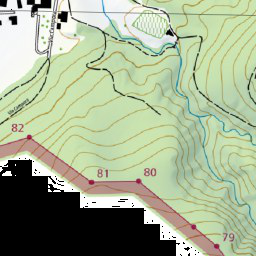

In [54]:
Img.fromarray(np5) #, mode='RGB')

(!) So naive approach won:t work, we need to "smart-select" whitish stuff starting at some white corner. This is what `flood` does.
We need to make sure "tolerance" catches the grey cross which is sometimes present on partial tiles (not just empty ones :-|). (It's fine to be a bit too tolerant as we'll fill something in anyway)
Its darkest grey (`imd3` above) is `(244, 244, 244)` so 5% will suffice.

Doc: [skimage.segmentation.flood_fill](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html)
See especially the last example with [mask post-processing](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html#flood-fill-in-hsv-space-and-mask-post-processing)

The concept of using morphological closing to get rid of artifacts is explained [here](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#closing)


Unfortunately flood_fill does not support RGB

In [55]:
[im5.getpixel((x, y)) for x in (0,255) for y in (0,255)]

[(0, 0, 2), (255, 255, 255), (202, 231, 183), (176, 191, 148)]

In [109]:
def white_corners(im):
    # while offset <= 50: offset +=10 ; 
    c = [(x, y) for x in (0,255) for y in (0,255) if im.getpixel((x, y)) == (255, 255, 255)]
    return c[0] if c else (None, None)

yseed, xseed = white_corners(im5)  # yes, reversed .....

CPU times: user 286 µs, sys: 0 ns, total: 286 µs
Wall time: 291 µs
CPU times: user 1.63 ms, sys: 244 µs, total: 1.87 ms
Wall time: 1.32 ms


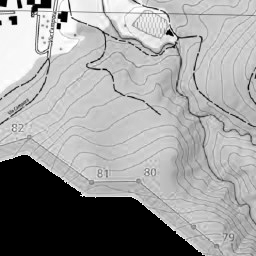

In [163]:
from skimage.segmentation import flood, flood_fill
%time imred = G.to_numpy(im5)[..., 0]
%time Img.fromarray(flood_fill(imred, (xseed, yseed), 0, tolerance=12), 'L')
# flood_fill(imr, c, (0,0,255), tolerance=12)

## Tile merge

CPU times: user 1.35 ms, sys: 201 µs, total: 1.55 ms
Wall time: 1.01 ms
CPU times: user 10 ms, sys: 264 µs, total: 10.3 ms
Wall time: 8.09 ms


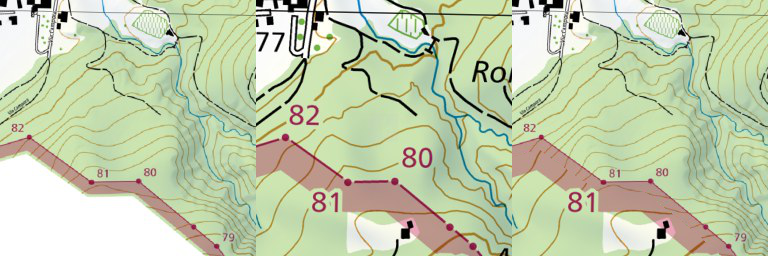

In [164]:
from skimage.morphology import erosion, dilation, disk

np5 = G.to_numpy(im5)
imred = np5[..., 1]
%time partial_mask = flood(imred, (xseed, yseed), tolerance=12)
%time partial_mask = dilation(partial_mask, disk(4))
np5[partial_mask] = np6[partial_mask]
G.pil_grid((im5, im6, Img.fromarray(np5)))

In [215]:
a = np.where(G.np_equal(np5, G.NP_WHITE))
a[0][0], a[1][0], np5[a[0][0], a[1][0]]

(9, 11, array([255, 255, 255], dtype=uint8))

In [195]:
np5[255, 0, :] == G.NP_WHITE

array([ True,  True,  True])

In [223]:
G.merge_partial(imd5, imd6)

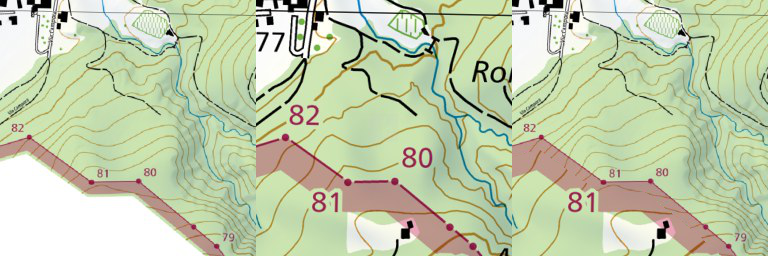

In [225]:
G.pil_grid([imd5, imd6, G.merge_partial(imd5, imd6)])

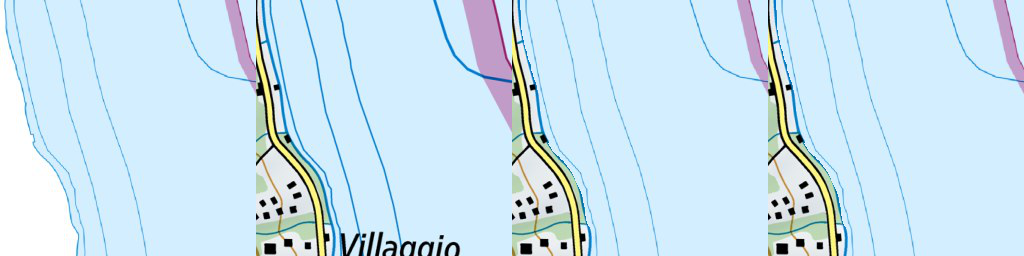

In [219]:
z, lng, lat = 16, 8.892, 45.93
imdp = M.lnglat2tile('ch.mbtiles', z, lng=lng, lat=lat)
assert(imdp)
imdf = M.lnglat2tile('zzcch.mbtiles', z, lng=lng, lat=lat)
assert(imdf)
G.pil_grid([imdp, imdf, G.merge_partial(imdp, imdf, dilate=4), G.merge_partial(imdp, imdf, dilate=0)])

In the above example, it's slightly better not to dilate (but we can:t really know when to do so, we'll have to activate dilation for all zoo 14)

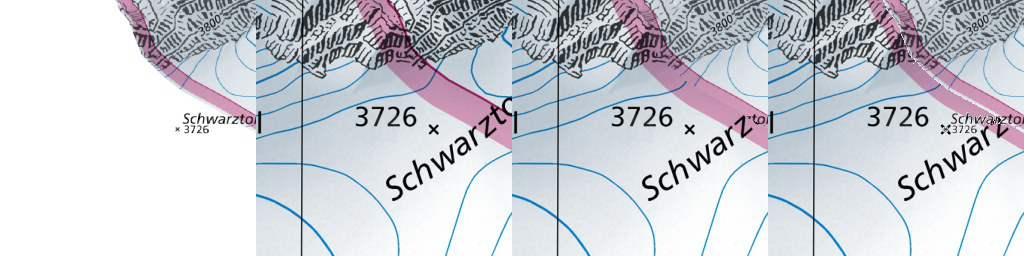

In [155]:
z, lng, lat = 16, 7.777, 45.93
imdp = M.lnglat2tile('ch.mbtiles', z, lng=lng, lat=lat)
assert(imdp)
imdf = M.lnglat2tile('zzcch.mbtiles', z, lng=lng, lat=lat)
assert(imdf)
G.pil_grid([imdp, imdf, G.merge_partial(imdp, imdf, dilate=4), G.merge_partial(imdp, imdf, dilate=0)])

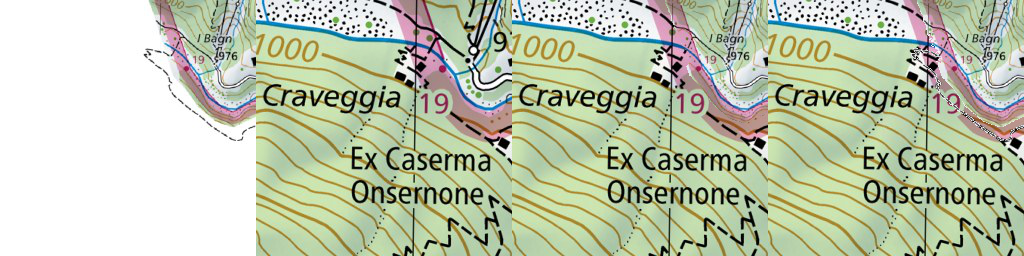

In [159]:
z, lng, lat = 16, 8.54, 46.198
imdp = M.lnglat2tile('ch.mbtiles', z, lng=lng, lat=lat)
assert(imdp)
imdf = M.lnglat2tile('zzcch.mbtiles', z, lng=lng, lat=lat)
assert(imdf)
G.pil_grid([imdp, imdf, G.merge_partial(imdp, imdf, dilate=4), G.merge_partial(imdp, imdf, dilate=0)])

Finally, an example where z16 actually gives more data.

In [ ]:
imdlake = M.lnglat2tile('zzcch.mbtiles', 16, lng=8.912, lat=45.918)
assert(imdlake)
# Img.open(io.BytesIO(imdlake))
Image(data=imdlake)

## Annex - count colors with numpy instead of PIL.getcolors()

In [173]:
dict((c, cnt) for cnt, c in im5.getcolors(65535))[(255,255,255)]

10316

In [186]:
%time [cnt for (cnt, c) in im5.getcolors(65535) if c == (255,255,255)]

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.8 ms


[10316]

In [189]:
%time np.array(im5)
%time np5 = G.to_numpy(im5)
%time np.sum(np.all(np5 == np.array((255,255, 255)), axis=2))

CPU times: user 1.67 ms, sys: 0 ns, total: 1.67 ms
Wall time: 1.51 ms
CPU times: user 130 µs, sys: 19 µs, total: 149 µs
Wall time: 153 µs
CPU times: user 2.38 ms, sys: 0 ns, total: 2.38 ms
Wall time: 1.87 ms


10316

## Test tileset

In [257]:
import sqlite3
dbc = sqlite3.connect('ch.mbtiles').cursor()
ts = M.Tileset.from_db(dbc)
print(len(ts), round(sys.getsizeof(ts.s)/1024**2, 1), 'MB')
dbc.close()

360451 16.0 MB


In [259]:
e = next(iter(ts.s))
sys.getsizeof(e), e

(32, 279350650206)

In [251]:
format(M.Tileset.zxy_to_i(1, 0, 1), '#039b')

'0b0010000000000000000000000000000000001'

In [252]:
M.Tileset.i_to_zxy(M.Tileset.zxy_to_i(1, 2, 3))

(1, 2, 3)

In [253]:
M.Tileset.i_to_zxy(M.Tileset.zxy_to_i(16, 1001, 1002))

(16, 1001, 1002)

### Annex - Which color channel to keep for best results? → RED

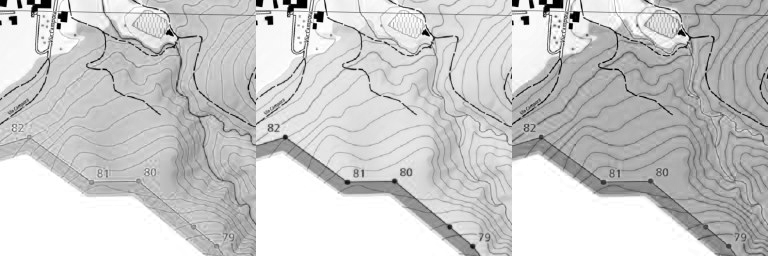

In [99]:
#for i in range(3):
G.pil_grid([Img.fromarray(G.to_numpy(im5)[..., i]) for i in range(3)])

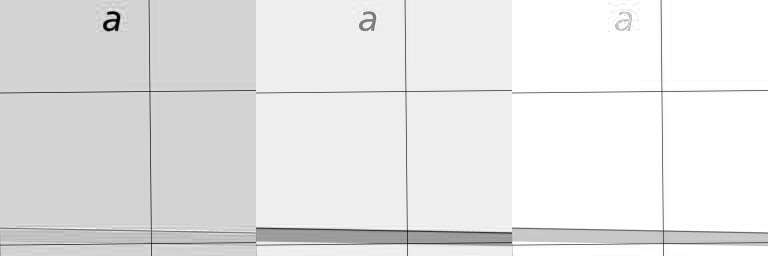

In [104]:
G.pil_grid([Img.fromarray(G.to_numpy(imlake)[..., i]) for i in range(3)])